# Analysis B-Point Algorithms

## Setup and Helper Functions

### Imports

In [39]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import seaborn as sns
from biopsykit.utils.dataframe_handling import multi_xs
from fau_colors import cmaps, register_fausans_font
from IPython.display import Markdown

from pepbench.data_handling import (
    add_unique_id_to_results_dataframe,
    compute_improvement_outlier_correction,
    compute_pep_performance_metrics,
    get_error_by_group,
)
from pepbench.datasets import EmpkinsDataset, GuardianDataset
from pepbench.export import (
    convert_to_latex,
    create_algorithm_result_table,
    create_nan_reason_table,
    create_outlier_correction_table,
)
from pepbench.io import load_challenge_results_from_folder
from pepbench.plotting.results import (
    boxplot_algorithm_performance,
    paired_plot_error_outlier_correction,
    regplot_error_heart_rate,
    residual_plot_pep,
    residual_plot_pep_heart_rate,
    residual_plot_pep_participant,
    residual_plot_pep_phase,
    violinplot_algorithm_performance,
)
from pepbench.utils import get_nan_reason_mapping, rename_algorithms, rename_metrics, styling

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.37254901960784315, 0.48627450980392156, 0.6392156862745098),
 (0.6666666666666666, 0.7647058823529411, 0.8196078431372549),
 (1.0, 0.8235294117647058, 0.44313725490196076),
 (0.37254901960784315, 0.7725490196078432, 0.9254901960784314),
 (0.5372549019607843, 0.803921568627451, 0.4745098039215686),
 (0.8627450980392157, 0.4117647058823529, 0.48627450980392156)]

In [41]:
root_path = Path("../../")

In [42]:
deploy_type = "local"

config_dict = json.load(root_path.joinpath("config.json").open(encoding="utf-8"))

empkins_base_path = Path(config_dict[deploy_type]["empkins_path"])
guardian_base_path = Path(config_dict[deploy_type]["guardian_path"])
print(empkins_base_path)

/Users/richer/Documents/PhD/Projects/EmpkinS/HealthPsychology_D03/Data/2024_08_PEP_Benchmarking/EmpkinS_Dataset


### Input Paths

In [43]:
result_path = root_path.joinpath("results")

### Output Paths

In [44]:
paper_path = json.load(root_path.joinpath("paper_path.json").open(encoding="utf-8"))["paper_path"]
paper_path = Path(paper_path)

export_path = root_path.joinpath("exports")
img_path = export_path.joinpath("plots")
stats_path = export_path.joinpath("stats")

img_path_paper = paper_path.joinpath("img")
tab_path_paper = paper_path.joinpath("tab")
suppl_img_path_paper = paper_path.joinpath("supplementary_material/img")
suppl_tab_path_paper = paper_path.joinpath("supplementary_material/tab")

bp.utils.file_handling.mkdirs(
    [
        result_path,
        export_path,
        img_path,
        stats_path,
        img_path_paper,
        tab_path_paper,
        suppl_img_path_paper,
        suppl_tab_path_paper,
    ]
)

In [45]:
algo_levels = ["b_point_algorithm", "outlier_correction_algorithm"]
algo_level_mapping = dict(zip(algo_levels, ["B-Point Algorithm", "Outlier Correction"]))

In [46]:
deploy_type = "local"

config_dict = json.load(root_path.joinpath("config.json").open(encoding="utf-8"))

empkins_base_path = Path(config_dict[deploy_type]["empkins_path"])
guardian_base_path = Path(config_dict[deploy_type]["guardian_path"])
print(empkins_base_path)

/Users/richer/Documents/PhD/Projects/EmpkinS/HealthPsychology_D03/Data/2024_08_PEP_Benchmarking/EmpkinS_Dataset


## EmpkinS Dataset

In [47]:
dataset_empkins = EmpkinsDataset(empkins_base_path, use_cache=True, only_labeled=True)
dataset_empkins

EmpkinsDataset [150 groups/rows]

       participant condition    phase
   0        VP_001      tsst     Prep
   1        VP_001      tsst  Pause_1
   2        VP_001      tsst     Talk
   3        VP_001      tsst     Math
   4        VP_001      tsst  Pause_5
   ..          ...       ...      ...
   145      VP_032     ftsst     Prep
   146      VP_032     ftsst  Pause_1
   147      VP_032     ftsst     Talk
   148      VP_032     ftsst     Math
   149      VP_032     ftsst  Pause_5
   
   [150 rows x 3 columns]

In [48]:
results_empkins = load_challenge_results_from_folder(
    result_path.joinpath("empkins_dataset_b_point"),
    index_cols_per_sample=["participant", "condition", "phase"],
)

In [49]:
results_per_sample_empkins = results_empkins.per_sample.droplevel([0])
results_agg_total_empkins = results_empkins.agg_total.droplevel([0])
results_per_sample_empkins.head()

heartbeat_id  \
                                                                                               estimated   
b_point_algorithm               outlier_correction_algorithm participant condition phase id                
arbol2017-isoelectric-crossings forouzanfar2018              VP_001      tsst      Prep  0             0   
                                                                                         1             1   
                                                                                         2             2   
                                                                                         3             3   
                                                                                         4             4   

                                                                                                       \
                                                                                            reference   
b_point_algorithm               outlier_correction_algorithm participant condition phase id             
arbol2017-isoelectric-crossings forouzanfar2018              VP_001      tsst      Prep  0          0   
                                                                                         1          1   
                                                                                         2          2   
                                                                                         3          3   
                                                                                         4          4   

                                                                                            heartbeat_start_sample  \
                                                                                                         estimated   
b_point_algorithm               outlier_correction_algorithm participant condition phase id                          
arbol2017-isoelectric-crossings forouzanfar2018              VP_001      tsst      Prep  0                     394   
                                                                                         1                     984   
                                                                                         2                    1569   
                                                                                         3                    2134   
                                                                                         4                    2684   

                                                                                                       \
                                                                                            reference   
b_point_algorithm               outlier_correction_algorithm participant condition phase id             
arbol2017-isoelectric-crossings forouzanfar2018              VP_001      tsst      Prep  0        399   
                                                                                         1        985   
                                                                                         2       1569   
                                                                                         3       2134   
                                                                                         4       2684   

                                                                                            heartbeat_end_sample  \
                                                                                                       estimated   
b_point_algorithm               outlier_correction_algorithm participant condition phase id                        
arbol2017-isoelectric-crossings forouzanfar2018              VP_001      tsst      Prep  0                   984   
                                                                                         1                  1569   
                    

In [50]:
selected_algos_for_plotting_empkins = [
    ("debski1993-second-derivative", "none"),
    ("lozano2007-linear-regression", "none"),
    ("forouzanfar2018", "none"),
    ("drost2022", "none"),
]

In [51]:
selected_algos_for_residual_empkins = ["drost2022", "lozano2007-linear-regression", "forouzanfar2018"]

In [52]:
selected_algos_for_residual_outlier_correction_empkins = [
    "drost2022",
    "debski1993-second-derivative",
    "forouzanfar2018",
]
outlier_algos = ["none", "linear-interpolation", "forouzanfar2018"]
outlier_algos_rename = ["None", "LinInt", "For18"]

### Results Table

In [53]:
metrics_empkins = compute_pep_performance_metrics(results_per_sample_empkins, num_heartbeats=results_agg_total_empkins)
metrics_empkins.style.highlight_min(
    subset=["Mean Absolute Error [ms]", "Mean Absolute Relative Error [%]"], props="background-color: PaleGreen;"
)

In [54]:
metrics_empkins_table = metrics_empkins.xs("none", level="outlier_correction_algorithm")
metrics_empkins_table.style.highlight_min(
    subset=["Mean Absolute Error [ms]", "Mean Absolute Relative Error [%]"], props="background-color: PaleGreen;"
)

In [55]:
result_table = create_algorithm_result_table(metrics_empkins_table)

latex_output = convert_to_latex(
    result_table,
    collapse_index_columns=False,
    column_header_bold=True,
    column_format="p{1.0cm}S[table-format=1.1(2)]S[table-format=1.1(2)]S[table-format=1.1(2)]p{1.75cm}",
    caption=r"Results of the B-point extraction algorithms (without outlier correction) on the \textit{EmpkinS Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order.",
    label="tab:b_point_results_empkins",
)

# fix pandas bug that does not format the last column name in bold
latex_output = latex_output.replace(r"{Invalid", r"{\bfseries Invalid")
# some manual post-processing
latex_output = latex_output.replace(
    r"{} & {\bfseries \ac{MAE} [ms]}", r"{\bfseries B-point Algorithm} & {\bfseries \ac{MAE} [ms]}"
)
latex_output = latex_output.replace(r"{B-Point Detection} & {} & {} & {} & {} \\", "")


tab_path_paper.joinpath("tab_b_point_results_empkins.tex").open(mode="w+").write(latex_output)

print(latex_output)

\begin{table}[ht]
\centering
\sisetup{separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{Results of the B-point extraction algorithms (without outlier correction) on the \textit{EmpkinS Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order.}
\label{tab:b_point_results_empkins}
\begin{tabular}{p{1.0cm}S[table-format=1.1(2)]S[table-format=1.1(2)]S[table-format=1.1(2)]p{1.75cm}}
\toprule
{\bfseries B-point Algorithm} & {\bfseries \ac{MAE} [ms]} & {\bfseries \ac{ME} [ms]} & {\bfseries \ac{MARE} [\%]} & {\bfseries Invalid\newline PEPs} \\

\midrule
Dro22 & 14.9 \pm 14.7 & -10.1 \pm 18.4 & 18.8 \pm 19.9 & 56 (1.1 \%) \\
Deb93SD & 17.1 \pm 16.8 & 5.3 \pm 23.4 & 21.8 \pm 26.6 & 411 (8.2 \%) \\
Loz07QR & 21.6 \pm 15.0 & -16.9 \pm 20.2 & 30.5 \pm 30.6 & 39 (0.8 \%) \\
Loz07LR & 22.4 \pm 16.1 & -20.2 \pm 18.8 & 31.9 \pm 31.9 & 29 (0.6 \%) \\
For18 & 22.9 \pm 26.5 & 21.2 \pm 27.9 & 25.8 \pm 28.1 & 299 (6.0 \%) \\
Arb17TD & 23.7 \pm 18.4 & -19

### Plots

In [56]:
results_empkins_plot = multi_xs(
    data=results_per_sample_empkins, keys=selected_algos_for_plotting_empkins, level=algo_levels
)
results_empkins_plot = results_empkins_plot.droplevel("outlier_correction_algorithm")
results_empkins_plot = results_empkins_plot.reindex([s[0] for s in selected_algos_for_plotting_empkins], level=0)
results_empkins_plot.head()

heartbeat_id  \
                                                               estimated   
b_point_algorithm            participant condition phase id                
debski1993-second-derivative VP_001      ftsst     Math  1             1   
                                                         2             2   
                                                         3             3   
                                                         4             4   
                                                         5             5   

                                                                       \
                                                            reference   
b_point_algorithm            participant condition phase id             
debski1993-second-derivative VP_001      ftsst     Math  1          1   
                                                         2          2   
                                                         3          3   
                                                         4          4   
                                                         5          5   

                                                            heartbeat_start_sample  \
                                                                         estimated   
b_point_algorithm            participant condition phase id                          
debski1993-second-derivative VP_001      ftsst     Math  1                     796   
                                                         2                    1522   
                                                         3                    2245   
                                                         4                    2956   
                                                         5                    3629   

                                                                       \
                                                            reference   
b_point_algorithm            participant condition phase id             
debski1993-second-derivative VP_001      ftsst     Math  1        796   
                                                         2       1522   
                                                         3       2245   
                                                         4       2956   
                                                         5       3629   

                                                            heartbeat_end_sample  \
                                                                       estimated   
b_point_algorithm            participant condition phase id                        
debski1993-second-derivative VP_001      ftsst     Math  1                  1522   
                                                         2                  2245   
                                                         3                  2956   
                                                         4                  3629   
                                                         5                  4264   

                                                                       \
                                                            reference   
b_point_algorithm            participant condition phase id             
debski1993-second-derivative VP_001      ftsst     Math  1       1522   
                                                         2       2245   
                                                         3       2956   
                                                         4       3629   
                                                         5       4264   

                                                            q_peak_sample  \
                                                                estimated   
b_point_algorithm            participant condition phase id                 
debski1993-second-derivative VP_001      ftsst     Math  1           1025   
                          

#### Absolute Error

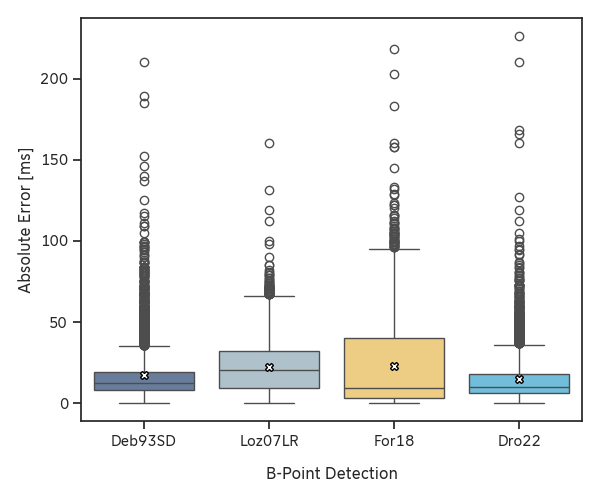

In [57]:
fig, ax = boxplot_algorithm_performance(
    results_empkins_plot,
    metric="absolute_error_per_sample_ms",
    showmeans=True,
    figsize=(6, 5),
)

fig.savefig(img_path.joinpath("img_boxplot_b_point_algorithms_mae_empkins.pdf"), transparent=True)

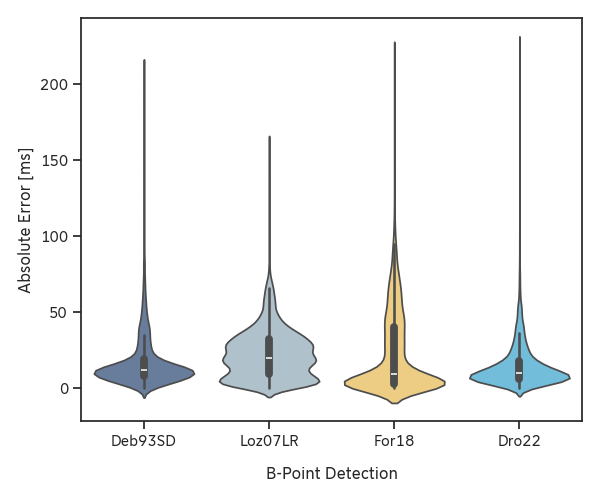

In [58]:
fig, ax = violinplot_algorithm_performance(
    results_empkins_plot,
    metric="absolute_error_per_sample_ms",
    figsize=(6, 5),
)

#### Absolute Error (with and without Outlier)

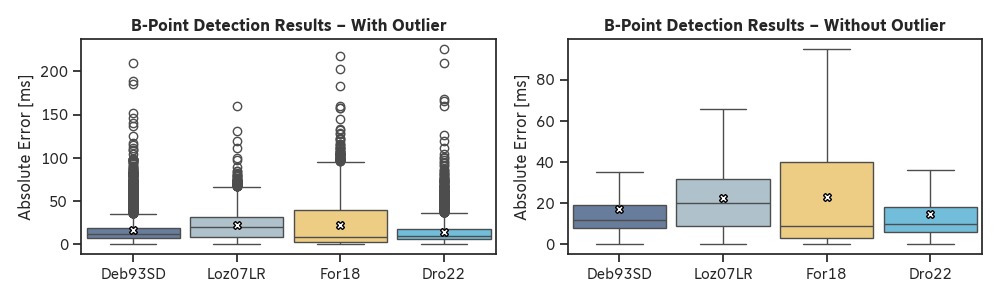

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

boxplot_algorithm_performance(
    results_empkins_plot,
    metric="absolute_error_per_sample_ms",
    showmeans=True,
    showfliers=True,
    width=0.9,
    title="B-Point Detection Results – With Outlier",
    fig=fig,
    ax=axs[0],
)
boxplot_algorithm_performance(
    results_empkins_plot,
    metric="absolute_error_per_sample_ms",
    showmeans=True,
    showfliers=False,
    width=0.9,
    title="B-Point Detection Results – Without Outlier",
    fig=fig,
    ax=axs[1],
)
for ax in axs:
    ax.set_xlabel(None)
fig.tight_layout()

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_boxplot_b_point_algorithms_mae_with_without_outlier_empkins.pdf"), transparent=True)

#### Error

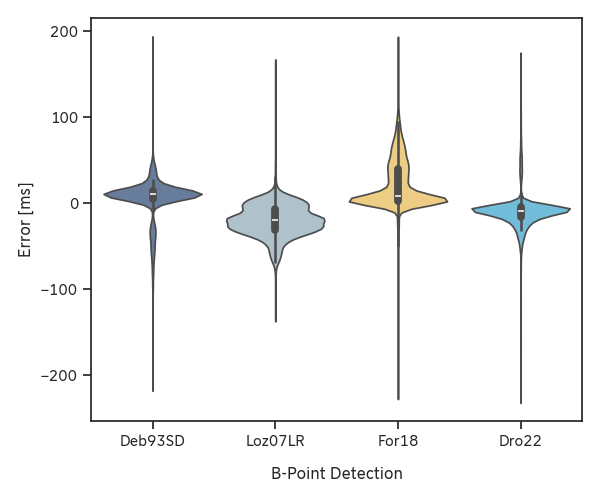

In [60]:
fig, ax = violinplot_algorithm_performance(
    results_empkins_plot,
    metric="error_per_sample_ms",
    figsize=(6, 5),
)

#### Error per Participant

In [61]:
error_per_participant_empkins = get_error_by_group(results_per_sample_empkins, grouper="participant")
error_per_participant_empkins = multi_xs(
    error_per_participant_empkins, selected_algos_for_plotting_empkins, level=algo_levels, axis=1
)
error_per_participant_empkins = error_per_participant_empkins.round(2)
error_per_participant_empkins = error_per_participant_empkins.rename(columns=rename_algorithms).rename(
    columns=rename_metrics
)

error_per_participant_empkins.style.highlight_max(props="background-color: Pink;")

In [62]:
latex_output = convert_to_latex(
    error_per_participant_empkins.style.highlight_max(props="background-color: Pink;").format_index(
        escape="latex", axis=0
    ),
    collapse_index_columns=False,
    column_header_bold=True,
    column_format="p{3.5cm}" + "S[table-format=2.2]" * len(error_per_participant_empkins.columns),
    caption=r"Mean Abolute Error of selected B-point extraction algorithms on the \textit{EmpkinS Dataset} per participant. The values with the highest errors are highlighted in red.",
    label="tab:b_point_results_per_participant_empkins",
)

# fix pandas bug that does not format the last column name in bold
latex_output = latex_output.replace(r"\begin{table}[ht]", r"\begin{table}[ht]\small")
latex_output = latex_output.replace(r"b_point_algorithm", r"\bfseries B-point Algorithm")
latex_output = latex_output.replace(r"outlier_correction_algorithm", r"\bfseries Outlier Correction Algorithm")
latex_output = latex_output.replace(r"{participant}", r"{Participant}")
latex_output = latex_output.replace(r"{metric}", r"{}")
latex_output = latex_output.replace(r"{\bfseries mean}", r"{Mean}")
latex_output = latex_output.replace(r"{\bfseries std}", r"{SD}")
latex_output = latex_output.replace(r"{std}", r"{SD}")
latex_output = latex_output.replace(r"\sisetup{", r"\sisetup{round-mode=places,round-precision=2,")

suppl_tab_path_paper.joinpath("tab_b_point_results_per_participant_empkins.tex").open(mode="w+").write(latex_output)

print(latex_output)

\begin{table}[ht]\small
\centering
\sisetup{round-mode=places,round-precision=2,separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{Mean Abolute Error of selected B-point extraction algorithms on the \textit{EmpkinS Dataset} per participant. The values with the highest errors are highlighted in red.}
\label{tab:b_point_results_per_participant_empkins}
\begin{tabular}{p{3.5cm}S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]}
\toprule
{} & \multicolumn{8}{r}{\bfseries Absolute Error [ms]} \\
{\bfseries B-point Algorithm} & \multicolumn{2}{r}{\bfseries Deb93SD} & \multicolumn{2}{r}{\bfseries Dro22} & \multicolumn{2}{r}{\bfseries For18} & \multicolumn{2}{r}{\bfseries Loz07LR} \\
{\bfseries Outlier Correction Algorithm} & \multicolumn{2}{r}{\bfseries None} & \multicolumn{2}{r}{\bfseries None} & \multicolumn{2}{r}{\bfseries None} & \multicolumn{2}{r}{\b

#### Residual Plots

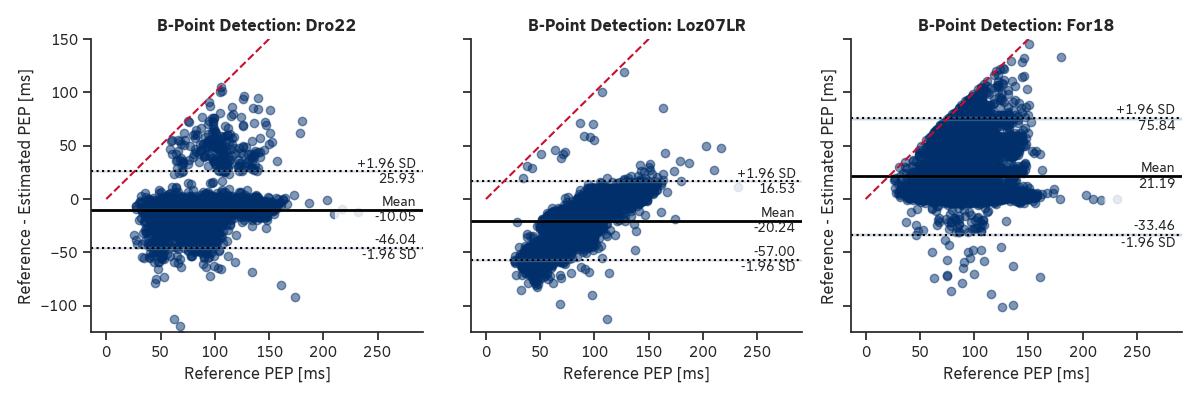

In [63]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = residual_plot_pep(
        results_empkins_plot,
        selected_algos_for_residual_empkins[i],
        alpha=0.5,
        show_upper_limit=True,
        annotate_fontsize="small",
        annotate_bbox=True,
        ax=ax,
    )
    if i != 0:
        axs[1].set_ylabel(None)
axs[0].set_ylim([-125, 150])

fig.tight_layout()

for path in [img_path, img_path_paper]:
    fig.savefig(path.joinpath("img_residual_plots_b_point_algorithms_empkins.pdf"), transparent=True)

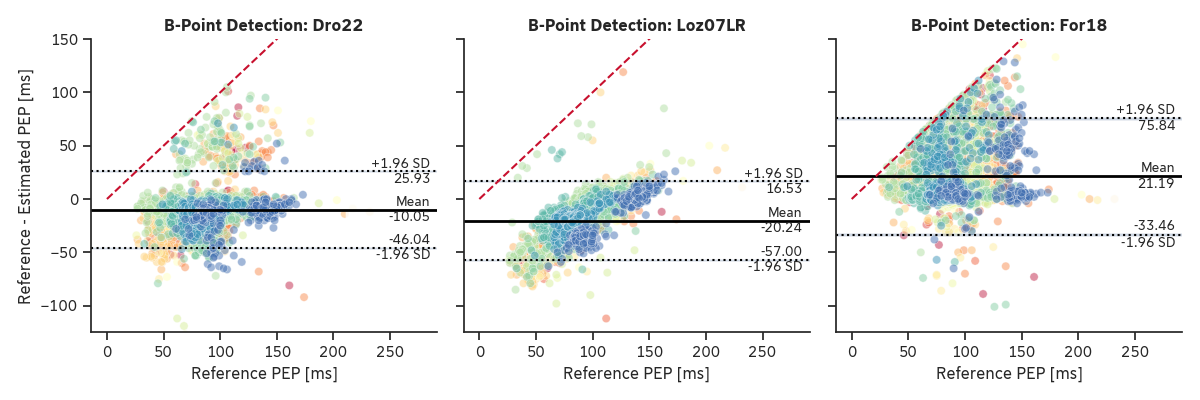

In [64]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = residual_plot_pep_participant(
        results_empkins_plot,
        selected_algos_for_residual_empkins[i],
        alpha=0.5,
        show_upper_limit=True,
        annotate_fontsize="small",
        annotate_bbox=True,
        show_legend=False,
        ax=ax,
    )
    if i != 0:
        axs[1].set_ylabel(None)
axs[0].set_ylim([-125, 150])

fig.tight_layout()

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_residual_plots_b_point_algorithms_per_participant_empkins.pdf"), transparent=True)

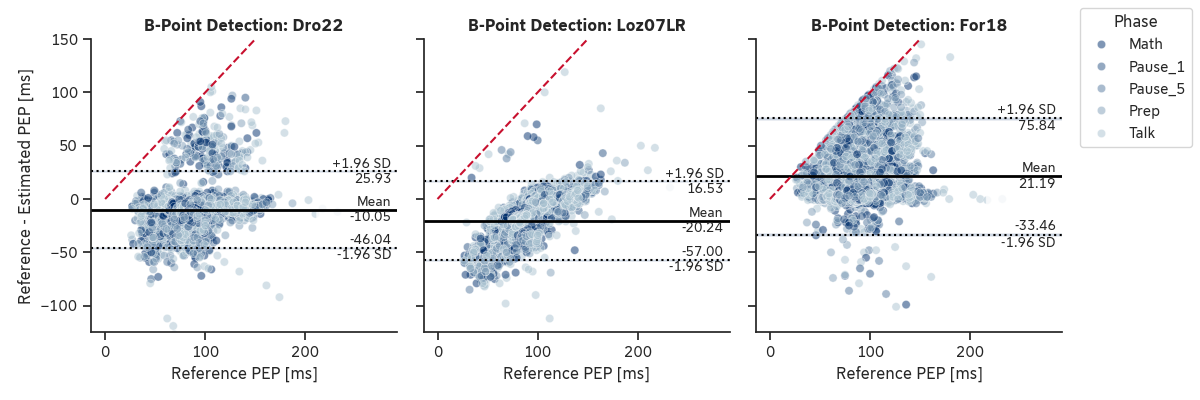

In [65]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = residual_plot_pep_phase(
        results_empkins_plot,
        selected_algos_for_residual_empkins[i],
        alpha=0.5,
        show_upper_limit=True,
        show_legend=(i == 0),
        annotate_fontsize="small",
        annotate_bbox=True,
        ax=ax,
    )
    if i != 0:
        axs[1].set_ylabel(None)

axs[0].set_ylim([-125, 150])

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_residual_plots_b_point_algorithms_per_phase_empkins.pdf"), transparent=True)

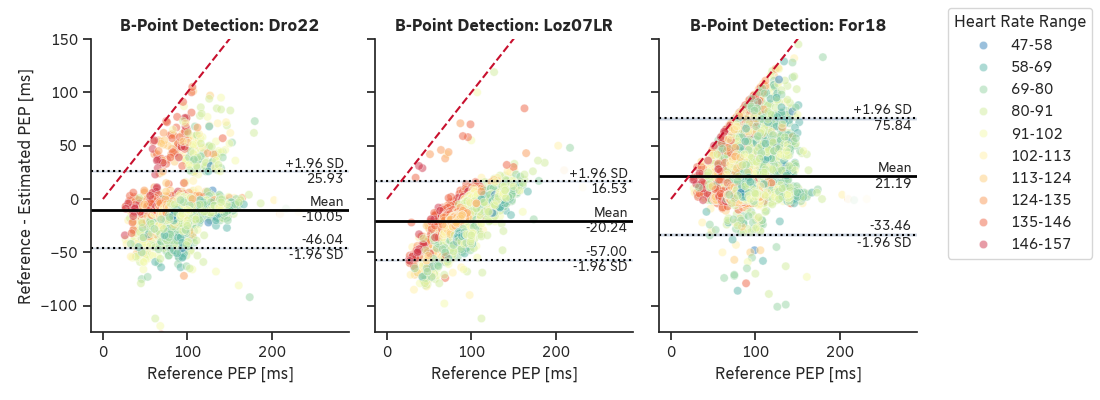

In [66]:
fig, axs = plt.subplots(ncols=3, figsize=(11, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = residual_plot_pep_heart_rate(
        results_empkins_plot,
        selected_algos_for_residual_empkins[i],
        alpha=0.5,
        show_upper_limit=True,
        show_legend=(i == 0),
        annotate_fontsize="small",
        annotate_bbox=True,
        ax=ax,
    )
    if i != 0:
        axs[1].set_ylabel(None)

axs[0].set_ylim([-125, 150])


for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_residual_plots_b_point_algorithms_heart_rate_empkins.pdf"), transparent=True)

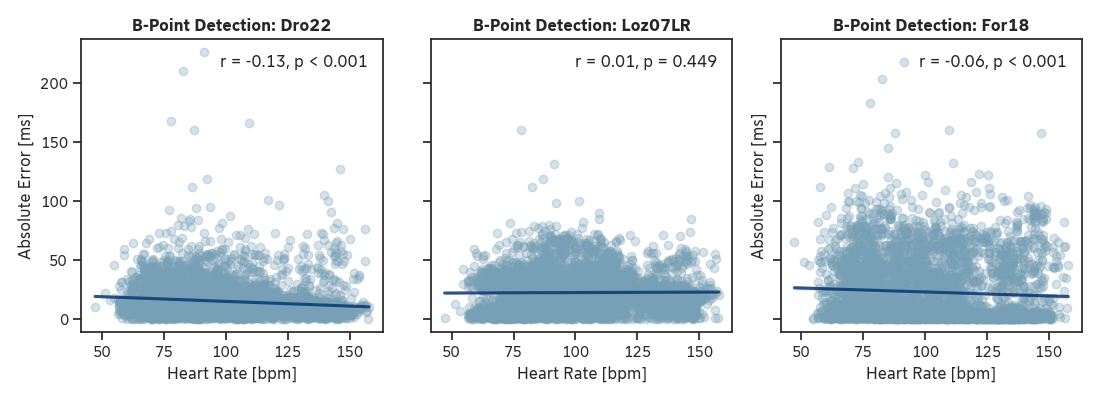

In [67]:
fig, axs = plt.subplots(ncols=3, figsize=(11, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = regplot_error_heart_rate(
        results_empkins_plot,
        selected_algos_for_residual_empkins[i],
        error_metric="absolute_error_per_sample_ms",
        add_corr_coeff=True,
        ax=ax,
    )
    if i != 0:
        axs[1].set_ylabel(None)

fig.tight_layout()

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_b_point_error_heart_rate_empkins.pdf"), transparent=True)

#### Effect of Outlier Correction on Estimation Error

In [68]:
metrics_empkins_outlier = create_outlier_correction_table(metrics_empkins)
metrics_empkins_outlier_style = metrics_empkins_outlier.style.apply(
    styling.highlight_outlier_improvement, subset=["Mean Absolute Error [ms]", "Invalid PEPs"]
)
metrics_empkins_outlier_style

##### LaTeX

In [69]:
latex_output = convert_to_latex(
    metrics_empkins_outlier_style,
    collapse_index_columns=False,
    column_header_bold=True,
    siunitx=True,
    convert_css=True,
    column_format="p{1.5cm}p{1.5cm}"
    + ("S[table-column-width=0.75cm]" * (len(metrics_empkins_outlier_style.columns) - 3))
    + "p{1.0cm}" * 3,
    caption=r"Effect of Outlier Correction algorithms on the B-point extraction algorithms for the \textit{EmpkinS Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order. Resuls highlighted in \textcolor{LightGreen}{green} indicate an improvement of the metric through outlier correction, \textcolor{Pink}{red} indicate no improvement.",
    label="tab:outlier_correction_results_full_empkins",
)

# some manual post processing of latex output
latex_output = latex_output.replace(r"\sisetup{", r"\sisetup{round-mode=places,round-precision=2,")
latex_output = latex_output.replace(r"\bfseries \bfseries", r"\bfseries")
latex_output = latex_output.replace(r"\bfseries \bfseries", r"\bfseries")
latex_output = latex_output.replace(r"\bfseries \bfseries", r"\bfseries")
latex_output = latex_output.replace(r"\multicolumn{2}{r}", r"\multicolumn{2}{c}")
latex_output = latex_output.replace(r"Mean Absolute Error [ms]", r"MAE [ms]")
latex_output = latex_output.replace(r"Mean Error [ms]", r"ME [ms]")
latex_output = latex_output.replace(r"Mean Absolute Relative Error [\%]", r"MARE [\%]")
latex_output = latex_output.replace(r"{B-Point Detection}", r"{B-Point\newline Detection}")

suppl_tab_path_paper.joinpath("tab_outlier_correction_results_full_empkins.tex").open(mode="w+").write(latex_output)

print(latex_output)

\begin{table}[ht]
\centering
\sisetup{round-mode=places,round-precision=2,separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{Effect of Outlier Correction algorithms on the B-point extraction algorithms for the \textit{EmpkinS Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order. Resuls highlighted in \textcolor{LightGreen}{green} indicate an improvement of the metric through outlier correction, \textcolor{Pink}{red} indicate no improvement.}
\label{tab:outlier_correction_results_full_empkins}
\begin{tabular}{p{1.5cm}p{1.5cm}S[table-column-width=0.75cm]S[table-column-width=0.75cm]S[table-column-width=0.75cm]S[table-column-width=0.75cm]S[table-column-width=0.75cm]S[table-column-width=0.75cm]p{1.0cm}p{1.0cm}p{1.0cm}}
\toprule
{} & {} & \multicolumn{2}{c}{\bfseries MAE [ms]} & \multicolumn{2}{c}{\bfseries ME [ms]} & \multicolumn{2}{c}{\bfseries MARE [\%]} & {\bfseries Valid PEPs} & {\bfseries Invalid PEPs} & {\bfseries Total PEPs} \\

#### Horizontal Table

In [70]:
metrics_empkins_outlier_unstack = metrics_empkins_outlier[["Mean Absolute Error [ms]"]]
metrics_empkins_outlier_unstack = (
    metrics_empkins_outlier_unstack.unstack(sort=False).reorder_levels([0, 2, 1], axis=1).sort_index(axis=1)
)
metrics_empkins_outlier_unstack = metrics_empkins_outlier_unstack.reindex(outlier_algos_rename, level=1, axis=1)
metrics_empkins_outlier_unstack

Mean Absolute Error [ms]                                   \
Outlier Correction                     None                LinInt              
                                       Mean         SD       Mean         SD   
B-Point Detection                                                              
Dro22                             14.859426  14.743126  15.389102  14.810659   
Deb93SD                           16.935217  17.106120  17.118264  17.252294   
For18                             21.430054  25.554994  22.908317  26.490574   
Loz07QR                           21.640597  15.043446  22.592622  16.506424   
Loz07LR                           22.405955  16.106866  23.679743  18.327043   
Arb17IC                           23.300527  15.284143  24.350535  15.960594   
She90                             23.310331  15.311318  23.791038  14.679082   
Arb17TD                           23.715650  18.357604  25.227066  18.773167   
Ste85                             24.185143  28.926652  26.249049  30.906628   
Arb17SD                           38.794209  20.172263  41.897327  21.192030   

                                          
Outlier Correction      For18             
                         Mean         SD  
B-Point Detection                         
Dro22               15.227649  14.727817  
Deb93SD             17.062323  16.819534  
For18               21.771802  25.701337  
Loz07QR             22.514816  16.367941  
Loz07LR             23.593040  18.219971  
Arb17IC             23.446132  15.282540  
She90               23.523204  15.500101  
Arb17TD             25.043892  18.724422  
Ste85               24.465989  28.985948  
Arb17SD             39.371001  20.173986

##### To LaTeX

In [71]:
result_table = create_algorithm_result_table(metrics_empkins[["Mean Absolute Error [ms]"]])
result_table = result_table.unstack("Outlier Correction").reindex(result_table.xs("None", level=-1).index, level=0)
result_table = result_table.reindex(outlier_algos_rename, level="Outlier Correction", axis=1)

latex_output = convert_to_latex(
    result_table.style.apply(styling.highlight_min_uncertainty, axis=1),
    collapse_index_columns=False,
    column_header_bold=True,
    siunitx=False,
    column_format="p{1.0cm}p{1.5cm}p{1.5cm}p{1.5cm}",
    caption=r"\ac{MAE} of the Outlier Correction algorithms on the B-point extraction algorithms on the \textit{EmpkinS Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order. The lowest \ac{MAE} values per algorithm are highlighted in \textbf{bold}. \ac{MAE} values are provided in milliseconds as (\(M\,\pm\,SD\)).",
    label="tab:outlier_correction_results_empkins",
)

# some manual post-processing
latex_output = latex_output.replace(
    r"\multicolumn{3}{r}{\bfseries Mean Absolute Error [ms]}",
    r"\multicolumn{3}{l}{\bfseries Outlier Correction Algorithm}",
)
latex_output = latex_output.replace(r"Outlier Correction & ", r"{\bfseries B-point Algorithm} & ")
latex_output = latex_output.replace(r"B-Point Detection &  &  &  \\", r"")
latex_output = latex_output.replace(r" \pm ", r"\(\pm\)")

tab_path_paper.joinpath("tab_outlier_correction_results_empkins.tex").open(mode="w+").write(latex_output)

print(latex_output)

\begin{table}[ht]
\centering
\sisetup{separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{\ac{MAE} of the Outlier Correction algorithms on the B-point extraction algorithms on the \textit{EmpkinS Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order. The lowest \ac{MAE} values per algorithm are highlighted in \textbf{bold}. \ac{MAE} values are provided in milliseconds as (\(M\,\pm\,SD\)).}
\label{tab:outlier_correction_results_empkins}
\begin{tabular}{p{1.0cm}p{1.5cm}p{1.5cm}p{1.5cm}}
\toprule
 & \multicolumn{3}{l}{\bfseries Outlier Correction Algorithm} \\
{\bfseries B-point Algorithm} & \bfseries None & \bfseries LinInt & \bfseries For18 \\

\midrule
Dro22 & \bfseries 14.9\(\pm\)14.7 & 15.4\(\pm\)14.8 & 15.2\(\pm\)14.7 \\
Deb93SD & 17.1\(\pm\)16.8 & 17.1\(\pm\)17.3 & \bfseries 16.9\(\pm\)17.1 \\
Loz07QR & \bfseries 21.6\(\pm\)15.0 & 22.6\(\pm\)16.5 & 22.5\(\pm\)16.4 \\
Loz07LR & \bfseries 22.4\(\pm\)16.1 & 23.7\(\pm\)18.3 & 23.6\

#### Outlier Correction Residual Plots

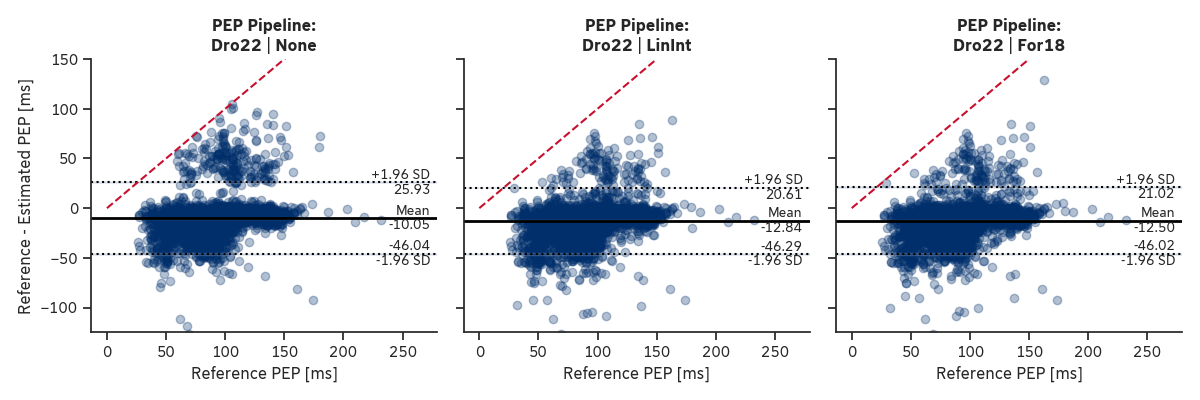

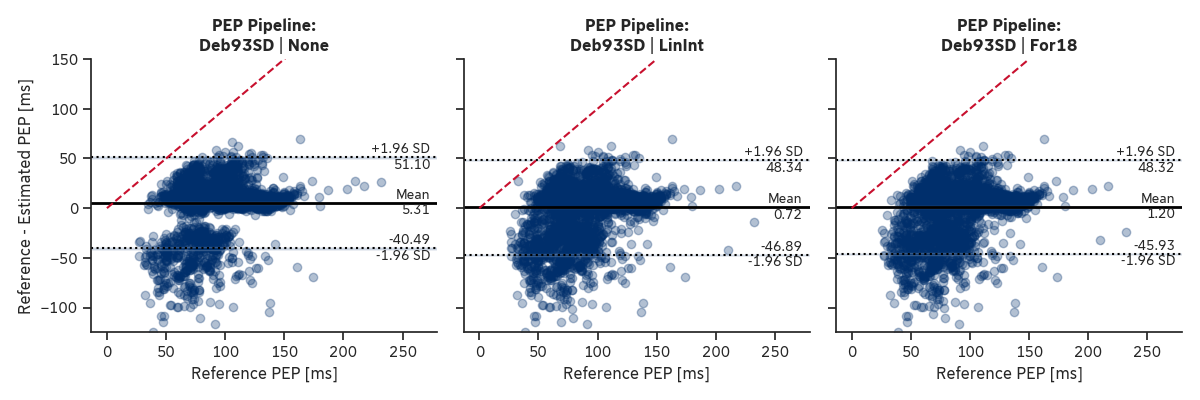

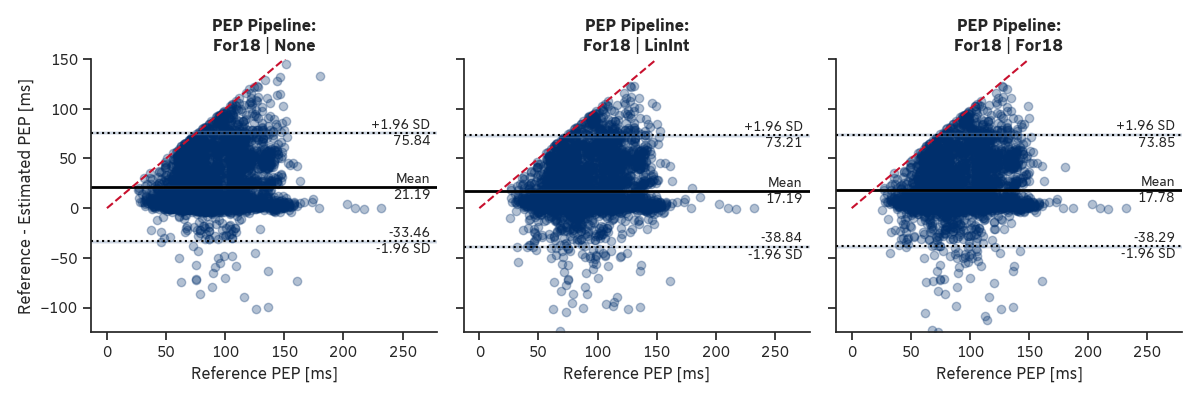

In [72]:
for algo in selected_algos_for_residual_outlier_correction_empkins:
    fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

    results_per_algorithm_plot_empkins = results_per_sample_empkins.xs(
        algo, level="b_point_algorithm", drop_level=False
    )

    for i, outlier_algo in enumerate(outlier_algos):
        selected_algo = [algo, outlier_algo]
        residual_plot_pep(
            results_per_sample_empkins, selected_algo, ax=axs[i], show_upper_limit=True, annotate_fontsize="small"
        )
        if i != 0:
            axs[i].set_ylabel(None)
        axs[i].set_ylim([-125, 150])

    fig.tight_layout()
    for path in [img_path, suppl_img_path_paper]:
        fig.savefig(
            path.joinpath(f"img_residual_plots_b_point_outlier_correction_{algo}_empkins.pdf"), transparent=True
        )

**B-point Algorithm**: drost2022

**Outlier Correction Algorithms**: none vs. linear-interpolation

improvement no change deterioration
improvement_percent    2.750809  88.55178      8.697411

**Outlier Correction Algorithms**: none vs. forouzanfar2018

improvement no change deterioration
improvement_percent    2.730583  89.54288      7.726537

**B-point Algorithm**: debski1993-second-derivative

**Outlier Correction Algorithms**: none vs. linear-interpolation

improvement  no change deterioration
improvement_percent    8.324254  86.859882      4.815864

**Outlier Correction Algorithms**: none vs. forouzanfar2018

improvement  no change deterioration
improvement_percent    8.215297  87.905862      3.878841

**B-point Algorithm**: forouzanfar2018

**Outlier Correction Algorithms**: none vs. linear-interpolation

improvement  no change deterioration
improvement_percent    7.870666  89.300149      2.829185

**Outlier Correction Algorithms**: none vs. forouzanfar2018

improvement  no change deterioration
improvement_percent    7.104871  90.533929        2.3612

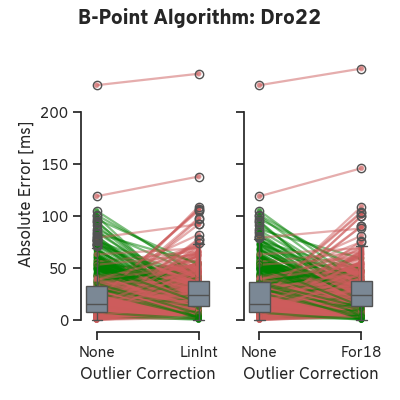

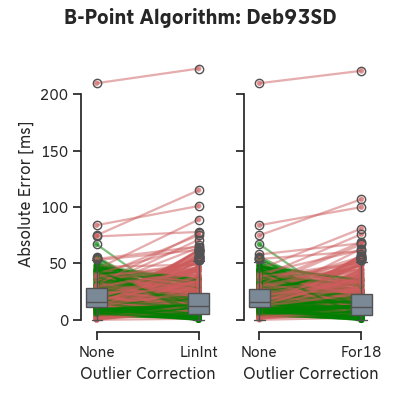

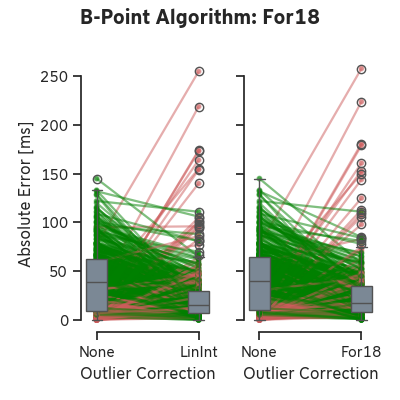

In [73]:
dv = "absolute_error_per_sample_ms"

for algo in selected_algos_for_residual_outlier_correction_empkins:
    results_per_algorithm_plot_empkins = results_per_sample_empkins.xs(algo, level="b_point_algorithm")
    data_plot_paired = add_unique_id_to_results_dataframe(results_per_algorithm_plot_empkins[[dv]])

    outlier_algo_combis = [(outlier_algos[0], outlier_algos[1]), (outlier_algos[0], outlier_algos[2])]

    fig, axs = plt.subplots(ncols=2, figsize=(4, 4), sharey=True)
    fig, axs = paired_plot_error_outlier_correction(
        data=data_plot_paired, outlier_algo_combis=outlier_algo_combis, dv=dv, title=algo, axs=axs
    )

    display(Markdown(f"**B-point Algorithm**: {algo}"))
    for outlier_algo in outlier_algo_combis:
        display(Markdown(f"""**Outlier Correction Algorithms**: {' vs. '.join(outlier_algo)}"""))
        display(compute_improvement_outlier_correction(data_plot_paired, outlier_algo))

    fig.tight_layout()
    for path in [img_path, suppl_img_path_paper]:
        fig.savefig(
            path.joinpath(f"img_paired_plot_b_point_outlier_correction_improvement_{algo}_empkins.pdf"),
            transparent=True,
        )

### `NaN` Reason Table

In [74]:
nan_reason_table_empkins = create_nan_reason_table(
    results_per_sample_empkins, outlier_algos=outlier_algos, use_short_names=True
)
nan_reason_table_empkins.head()

Reason                                No C  Neg. PEP  No IC  No Loc. Min.  \
B-Point Detection Outlier Correction                                        
Arb17IC           None                   5       116     15             0   
                  LinInt                 5        57      8             0   
                  For18                  5        57      8             0   
Arb17SD           None                   5       281      0             0   
                  LinInt                 5       160      0             0   

Reason                                No Mon. Incr.  No ZCs  
B-Point Detection Outlier Correction                         
Arb17IC           None                            0       0  
                  LinInt                          0       0  
                  For18                           0       0  
Arb17SD           None                            0       0  
                  LinInt                          0       0

##### To LaTeX

In [75]:
latex_output = convert_to_latex(
    nan_reason_table_empkins,
    column_format="p{1.5cm}" * 2 + "p{1.0cm}" * len(nan_reason_table_empkins.columns),
    column_header_bold=True,
    escape_columns=True,
    caption=r"Overview of invalid PEP reasons for different B-point algorithms on the \textit{EmpkinS Dataset}. Abbreviations: "
    + ", ".join([rf"\textit{{{k}}}: {v}" for k, v in get_nan_reason_mapping().items()]),
    label="tab:nan_reasons_empkins",
)

# some manual post-processing
latex_output = latex_output.replace(r"\centering", r"\small\centering")
latex_output = latex_output.replace(r"{Reason}", r"{\bfseries Reason}")

suppl_tab_path_paper.joinpath("tab_b_point_nan_reason_empkins.tex").open(mode="w+").write(latex_output)
print(latex_output)

\begin{table}[ht]
\small\centering
\sisetup{separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{Overview of invalid PEP reasons for different B-point algorithms on the \textit{EmpkinS Dataset}. Abbreviations: \textit{No C}: No C-point detected, \textit{No R}: No R-peak detected, \textit{Neg. PEP}: Negative PEP, \textit{No IC}: No Isoelectric Crossing before C-point detected, \textit{No Loc. Min.}: No Local Minimum detected, \textit{No Mon. Incr.}: No Monotonically Increasing Segment detected, \textit{No ZCs}: No Zero Crossings detected, \textit{Inv. B Window}: Invalid B-point Search Window}
\label{tab:nan_reasons_empkins}
\begin{tabular}{p{1.5cm}p{1.5cm}p{1.0cm}p{1.0cm}p{1.0cm}p{1.0cm}p{1.0cm}p{1.0cm}}
\toprule
{} & {\bfseries Reason} & {\bfseries No C} & {\bfseries Neg. PEP} & {\bfseries No IC} & {\bfseries No Loc. Min.} & {\bfseries No Mon. Incr.} & {\bfseries No ZCs} \\
{B-Point Detection} & {Outlier Correction} & {} & {} & {} & {} & {} & {} \\
\

## Guardian Dataset

In [76]:
dataset_guardian = GuardianDataset(guardian_base_path, use_cache=True, only_labeled=True)
dataset_guardian

GuardianDataset [106 groups/rows]

       participant          phase
   0       GDN0005          Pause
   1       GDN0005       Valsalva
   2       GDN0005  HoldingBreath
   3       GDN0005         TiltUp
   4       GDN0005       TiltDown
   ..          ...            ...
   101     GDN0029         TiltUp
   102     GDN0029       TiltDown
   103     GDN0030       Valsalva
   104     GDN0030  HoldingBreath
   105     GDN0030       TiltDown
   
   [106 rows x 2 columns]

In [77]:
results_guardian = load_challenge_results_from_folder(
    result_path.joinpath("guardian_dataset_b_point"),
    index_cols_per_sample=["participant", "phase"],
)

In [78]:
results_per_sample_guardian = results_guardian.per_sample.droplevel([0])
results_agg_total_guardian = results_guardian.agg_total.droplevel([0])
results_per_sample_guardian.head()

heartbeat_id  \
                                                                                     estimated   
b_point_algorithm               outlier_correction_algorithm participant phase id                
arbol2017-isoelectric-crossings forouzanfar2018              GDN0005     Pause 0             0   
                                                                               1             1   
                                                                               2             2   
                                                                               3             3   
                                                                               4             4   

                                                                                             \
                                                                                  reference   
b_point_algorithm               outlier_correction_algorithm participant phase id             
arbol2017-isoelectric-crossings forouzanfar2018              GDN0005     Pause 0          0   
                                                                               1          1   
                                                                               2          2   
                                                                               3          3   
                                                                               4          4   

                                                                                  heartbeat_start_sample  \
                                                                                               estimated   
b_point_algorithm               outlier_correction_algorithm participant phase id                          
arbol2017-isoelectric-crossings forouzanfar2018              GDN0005     Pause 0                     352   
                                                                               1                     808   
                                                                               2                    1252   
                                                                               3                    1686   
                                                                               4                    2116   

                                                                                             \
                                                                                  reference   
b_point_algorithm               outlier_correction_algorithm participant phase id             
arbol2017-isoelectric-crossings forouzanfar2018              GDN0005     Pause 0        352   
                                                                               1        808   
                                                                               2       1252   
                                                                               3       1686   
                                                                               4       2115   

                                                                                  heartbeat_end_sample  \
                                                                                             estimated   
b_point_algorithm               outlier_correction_algorithm participant phase id                        
arbol2017-isoelectric-crossings forouzanfar2018              GDN0005     Pause 0                   808   
                                                                               1                  1252   
                                                                               2                  1686   
                                                                               3                  2116   
                                                                               4                  2570   

                                                             

In [79]:
selected_algos_for_plotting_guardian = [
    ("debski1993-second-derivative", "none"),
    ("lozano2007-linear-regression", "none"),
    ("forouzanfar2018", "none"),
    ("drost2022", "none"),
]

In [80]:
selected_algos_for_residual_guardian = ["drost2022", "debski1993-second-derivative", "forouzanfar2018"]

In [81]:
selected_algos_for_residual_outlier_correction_guardian = [
    "drost2022",
    "debski1993-second-derivative",
    "forouzanfar2018",
]
outlier_algos = ["none", "linear-interpolation", "forouzanfar2018"]

### Results Table

In [82]:
metrics_guardian = compute_pep_performance_metrics(
    results_per_sample_guardian, num_heartbeats=results_agg_total_guardian
)
metrics_guardian.style.highlight_min(
    subset=["Mean Absolute Error [ms]", "Mean Absolute Relative Error [%]"], props="background-color: LightGreen;"
)

In [83]:
metrics_guardian_table = metrics_guardian.xs("none", level="outlier_correction_algorithm")
metrics_guardian_table.style.highlight_min(
    subset=["Mean Absolute Error [ms]", "Mean Absolute Relative Error [%]"], props="background-color: LightGreen;"
)

In [84]:
result_table = create_algorithm_result_table(metrics_guardian_table)

latex_output = convert_to_latex(
    result_table,
    collapse_index_columns=False,
    column_header_bold=True,
    column_format="p{1.0cm}S[table-format=1.1(2)]S[table-format=1.1(2)]S[table-format=1.1(2)]p{1.75cm}",
    caption=r"Results of the B-point extraction algorithms (without outlier correction) on the \textit{Guardian Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order.",
    label="tab:b_point_results_guardian",
)

# fix pandas bug that does not format the last column name in bold
latex_output = latex_output.replace(r"{Invalid", r"{\bfseries Invalid")
# some manual post-processing
latex_output = latex_output.replace(
    r"{} & {\bfseries \ac{MAE} [ms]}", r"{\bfseries B-point Algorithm} & {\bfseries \ac{MAE} [ms]}"
)
latex_output = latex_output.replace(r"{B-Point Detection} & {} & {} & {} & {} \\", "")


tab_path_paper.joinpath("tab_b_point_results_guardian.tex").open(mode="w+").write(latex_output)

print(latex_output)

\begin{table}[ht]
\centering
\sisetup{separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{Results of the B-point extraction algorithms (without outlier correction) on the \textit{Guardian Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order.}
\label{tab:b_point_results_guardian}
\begin{tabular}{p{1.0cm}S[table-format=1.1(2)]S[table-format=1.1(2)]S[table-format=1.1(2)]p{1.75cm}}
\toprule
{\bfseries B-point Algorithm} & {\bfseries \ac{MAE} [ms]} & {\bfseries \ac{ME} [ms]} & {\bfseries \ac{MARE} [\%]} & {\bfseries Invalid\newline PEPs} \\

\midrule
Loz07LR & 16.7 \pm 14.8 & -4.1 \pm 21.9 & 14.4 \pm 19.2 & 379 (5.7 \%) \\
Dro22 & 18.2 \pm 15.2 & -14.8 \pm 18.6 & 15.5 \pm 19.0 & 384 (5.8 \%) \\
For18 & 20.1 \pm 29.5 & 11.2 \pm 33.9 & 14.8 \pm 22.5 & 572 (8.7 \%) \\
Ste85 & 21.5 \pm 33.7 & 18.7 \pm 35.4 & 16.0 \pm 25.2 & 554 (8.4 \%) \\
Deb93SD & 23.0 \pm 23.9 & -9.2 \pm 31.8 & 19.1 \pm 25.0 & 385 (5.8 \%) \\
Loz07QR & 27.1 \pm 18.7 & 2

### Plots

In [85]:
results_guardian_plot = multi_xs(
    data=results_per_sample_guardian, keys=selected_algos_for_plotting_guardian, level=algo_levels
)
results_guardian_plot = results_guardian_plot.droplevel("outlier_correction_algorithm")
results_guardian_plot = results_guardian_plot.reindex([s[0] for s in selected_algos_for_plotting_guardian], level=0)
results_guardian_plot.head()

heartbeat_id  \
                                                             estimated   
b_point_algorithm            participant phase         id                
debski1993-second-derivative GDN0005     HoldingBreath 0             0   
                                                       1             1   
                                                       3             3   
                                                       4             4   
                                                       5             5   

                                                                     \
                                                          reference   
b_point_algorithm            participant phase         id             
debski1993-second-derivative GDN0005     HoldingBreath 0          0   
                                                       1          1   
                                                       3          3   
                                                       4          4   
                                                       5          5   

                                                          heartbeat_start_sample  \
                                                                       estimated   
b_point_algorithm            participant phase         id                          
debski1993-second-derivative GDN0005     HoldingBreath 0                     346   
                                                       1                     771   
                                                       3                    1553   
                                                       4                    1926   
                                                       5                    2306   

                                                                     \
                                                          reference   
b_point_algorithm            participant phase         id             
debski1993-second-derivative GDN0005     HoldingBreath 0        346   
                                                       1        771   
                                                       3       1553   
                                                       4       1926   
                                                       5       2306   

                                                          heartbeat_end_sample  \
                                                                     estimated   
b_point_algorithm            participant phase         id                        
debski1993-second-derivative GDN0005     HoldingBreath 0                   771   
                                                       1                  1173   
                                                       3                  1926   
                                                       4                  2306   
                                                       5                  2697   

                                                                     \
                                                          reference   
b_point_algorithm            participant phase         id             
debski1993-second-derivative GDN0005     HoldingBreath 0        771   
                                                       1       1173   
                                                       3       1926   
                                                       4       2306   
                                                       5       2697   

                                                          q_peak_sample  \
                                                              estimated   
b_point_algorithm            participant phase         id                 
debski1993-second-derivative GDN0005     HoldingBreath 0            476   
                                                       1            901   
                                                     

#### Absolute Error

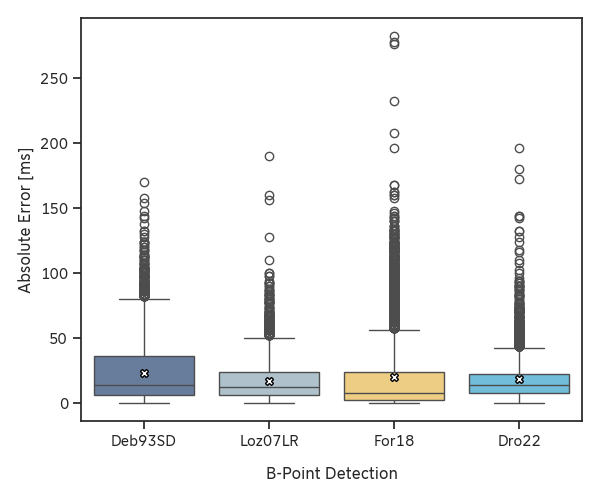

In [86]:
fig, ax = boxplot_algorithm_performance(
    results_guardian_plot,
    metric="absolute_error_per_sample_ms",
    showmeans=True,
    figsize=(6, 5),
)

fig.savefig(img_path.joinpath("img_boxplot_b_point_algorithms_mae_guardian.pdf"), transparent=True)

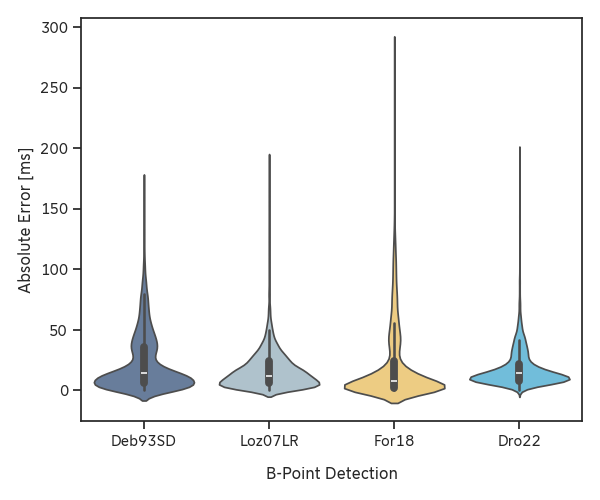

In [87]:
fig, ax = violinplot_algorithm_performance(
    results_guardian_plot,
    metric="absolute_error_per_sample_ms",
    showmeans=True,
    figsize=(6, 5),
)

#### Absolute Error (with and without Outlier)

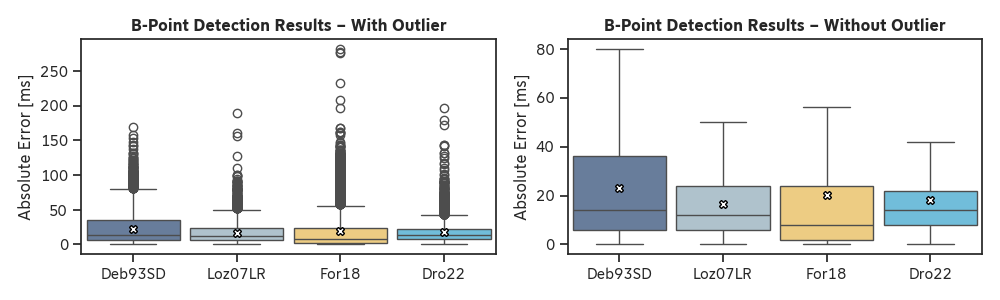

In [88]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

boxplot_algorithm_performance(
    results_guardian_plot,
    metric="absolute_error_per_sample_ms",
    showmeans=True,
    showfliers=True,
    width=0.9,
    title="B-Point Detection Results – With Outlier",
    fig=fig,
    ax=axs[0],
)
boxplot_algorithm_performance(
    results_guardian_plot,
    metric="absolute_error_per_sample_ms",
    showmeans=True,
    showfliers=False,
    width=0.9,
    title="B-Point Detection Results – Without Outlier",
    fig=fig,
    ax=axs[1],
)
for ax in axs:
    ax.set_xlabel(None)
fig.tight_layout()

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_boxplot_b_point_algorithms_mae_with_without_outlier_guardian.pdf"), transparent=True)

#### Error

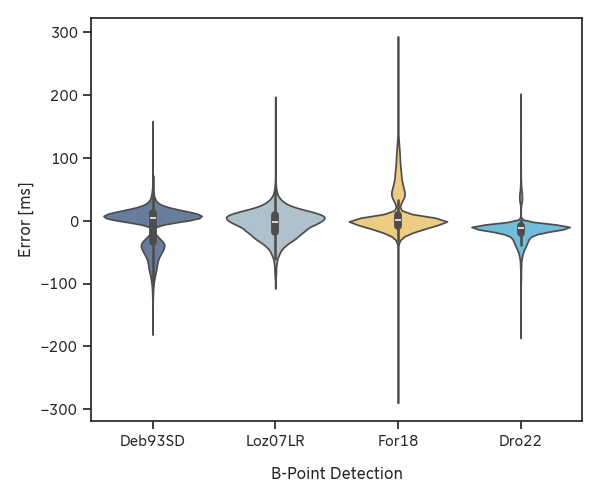

In [89]:
fig, ax = violinplot_algorithm_performance(
    results_guardian_plot,
    metric="error_per_sample_ms",
    figsize=(6, 5),
)

#### Error per Participant

In [90]:
error_per_participant_guardian = get_error_by_group(results_per_sample_guardian, grouper="participant")
error_per_participant_guardian = multi_xs(
    error_per_participant_guardian, selected_algos_for_plotting_guardian, level=algo_levels, axis=1
)
error_per_participant_guardian = error_per_participant_guardian.round(2)
error_per_participant_guardian = error_per_participant_guardian.rename(columns=rename_algorithms).rename(
    columns=rename_metrics
)

error_per_participant_guardian.style.highlight_max(props="background-color: Pink;")

In [91]:
latex_output = convert_to_latex(
    error_per_participant_guardian.style.highlight_max(props="background-color: Pink;").format_index(
        escape="latex", axis=0
    ),
    collapse_index_columns=False,
    column_header_bold=True,
    column_format="p{3.5cm}" + "S[table-format=2.2]" * len(error_per_participant_guardian.columns),
    caption=r"Mean Abolute Error of selected B-point extraction algorithms on the \textit{Guardian Dataset} per participant. The values with the highest errors are highlighted in red.",
    label="tab:b_point_results_per_participant_guardian",
)

# fix pandas bug that does not format the last column name in bold
latex_output = latex_output.replace(r"\begin{table}[ht]", r"\begin{table}[ht]\footnotesize")
latex_output = latex_output.replace(r"b_point_algorithm", r"\bfseries B-point Algorithm")
latex_output = latex_output.replace(r"outlier_correction_algorithm", r"\bfseries Outlier Correction Algorithm")
latex_output = latex_output.replace(r"{participant}", r"{Participant}")
latex_output = latex_output.replace(r"{metric}", r"{}")
latex_output = latex_output.replace(r"{\bfseries mean}", r"{Mean}")
latex_output = latex_output.replace(r"{\bfseries std}", r"{SD}")
latex_output = latex_output.replace(r"{std}", r"{SD}")
latex_output = latex_output.replace(r"\sisetup{", r"\sisetup{round-mode=places,round-precision=2,")

suppl_tab_path_paper.joinpath("tab_b_point_results_per_participant_guardian.tex").open(mode="w+").write(latex_output)

print(latex_output)

\begin{table}[ht]\footnotesize
\centering
\sisetup{round-mode=places,round-precision=2,separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{Mean Abolute Error of selected B-point extraction algorithms on the \textit{Guardian Dataset} per participant. The values with the highest errors are highlighted in red.}
\label{tab:b_point_results_per_participant_guardian}
\begin{tabular}{p{3.5cm}S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]S[table-format=2.2]}
\toprule
{} & \multicolumn{8}{r}{\bfseries Absolute Error [ms]} \\
{\bfseries B-point Algorithm} & \multicolumn{2}{r}{\bfseries Deb93SD} & \multicolumn{2}{r}{\bfseries Dro22} & \multicolumn{2}{r}{\bfseries For18} & \multicolumn{2}{r}{\bfseries Loz07LR} \\
{\bfseries Outlier Correction Algorithm} & \multicolumn{2}{r}{\bfseries None} & \multicolumn{2}{r}{\bfseries None} & \multicolumn{2}{r}{\bfseries None} & \multicolumn

#### Residual Plots

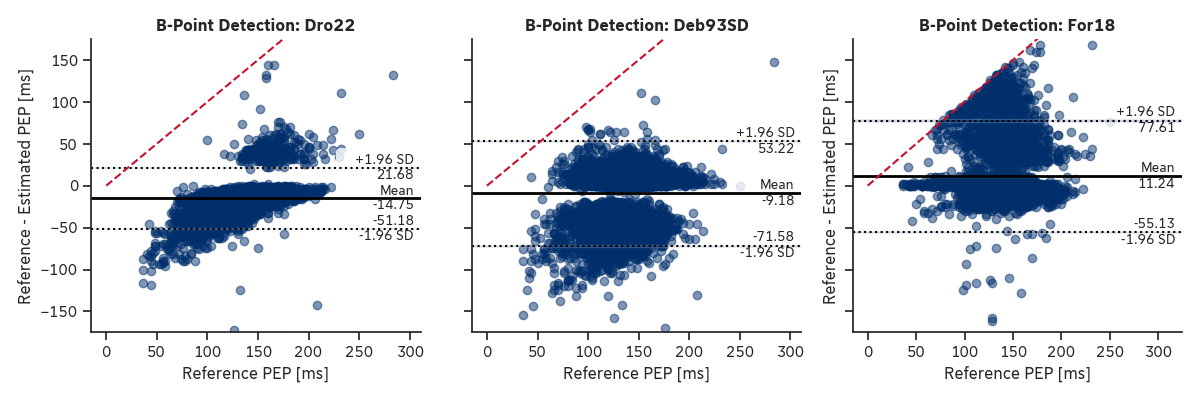

In [92]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = residual_plot_pep(
        results_guardian_plot,
        selected_algos_for_residual_guardian[i],
        alpha=0.5,
        show_upper_limit=True,
        annotate_fontsize="small",
        annotate_bbox=True,
        ax=ax,
    )
    if i != 0:
        axs[1].set_ylabel(None)
axs[0].set_ylim([-175, 175])

fig.tight_layout()

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_residual_plots_b_point_algorithms_guardian.pdf"), transparent=True)

/var/folders/qg/43ypdt795633pzrxkddmf5500000gn/T/ipykernel_56043/1597860894.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)


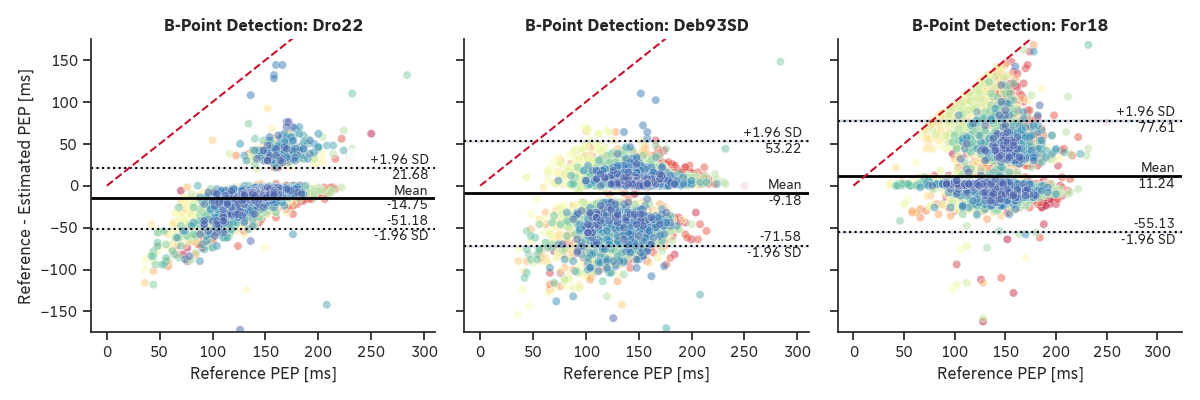

In [93]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = residual_plot_pep_participant(
        results_guardian_plot,
        selected_algos_for_residual_guardian[i],
        alpha=0.5,
        show_upper_limit=True,
        annotate_fontsize="small",
        annotate_bbox=True,
        ax=ax,
    )
    if i != 0:
        axs[1].set_ylabel(None)
axs[0].set_ylim([-175, 175])

fig.tight_layout()

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_residual_plots_b_point_algorithms_per_participant_guardian.pdf"), transparent=True)

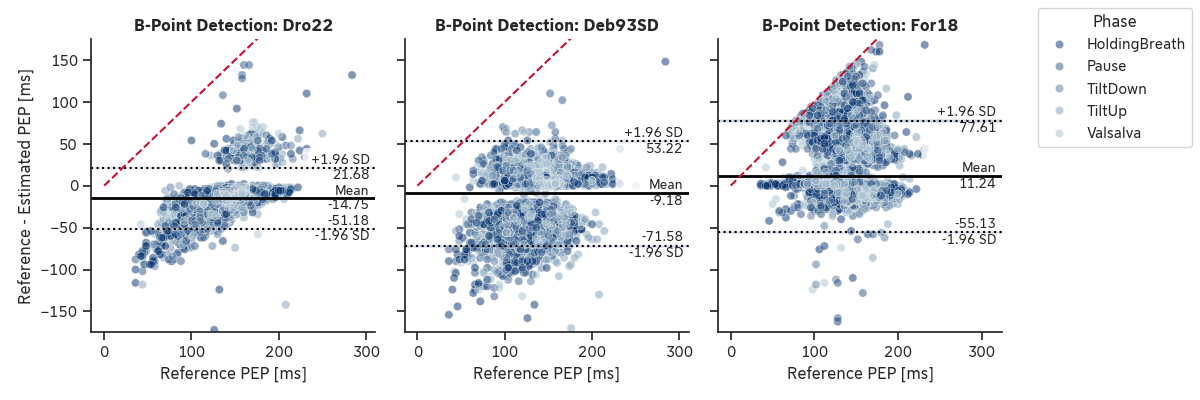

In [94]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = residual_plot_pep_phase(
        results_guardian_plot,
        selected_algos_for_residual_guardian[i],
        alpha=0.5,
        show_legend=(i == 0),
        show_upper_limit=True,
        annotate_fontsize="small",
        annotate_bbox=True,
        ax=ax,
        rect=(0, 0, 0.85, 1),
    )
    if i != 0:
        axs[1].set_ylabel(None)
axs[0].set_ylim([-175, 175])

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_residual_plots_b_point_algorithms_per_phase_guardian.pdf"), transparent=True)

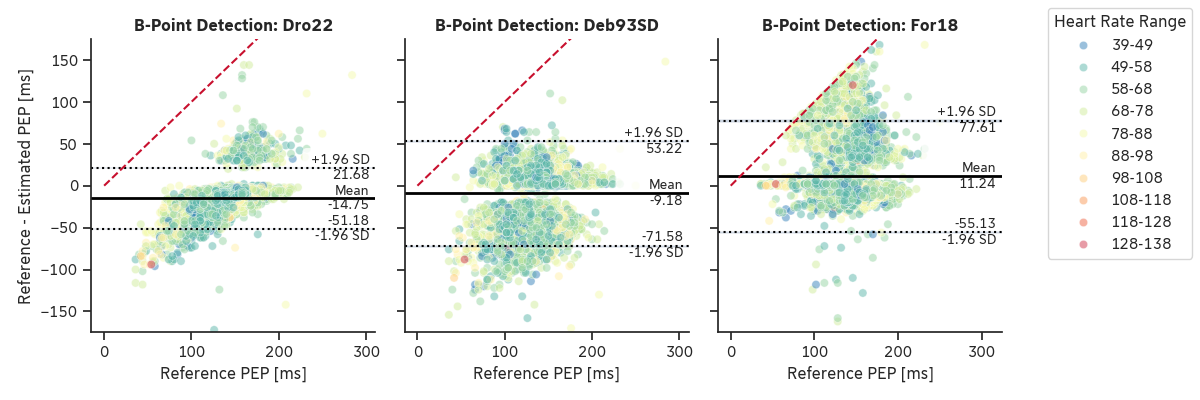

In [95]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = residual_plot_pep_heart_rate(
        results_guardian_plot,
        selected_algos_for_residual_guardian[i],
        alpha=0.5,
        show_legend=(i == 0),
        show_upper_limit=True,
        annotate_fontsize="small",
        annotate_bbox=True,
        ax=ax,
    )
    if i != 0:
        axs[1].set_ylabel(None)
axs[0].set_ylim([-175, 175])

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_residual_plots_b_point_algorithms_heart_rate_guardian.pdf"), transparent=True)

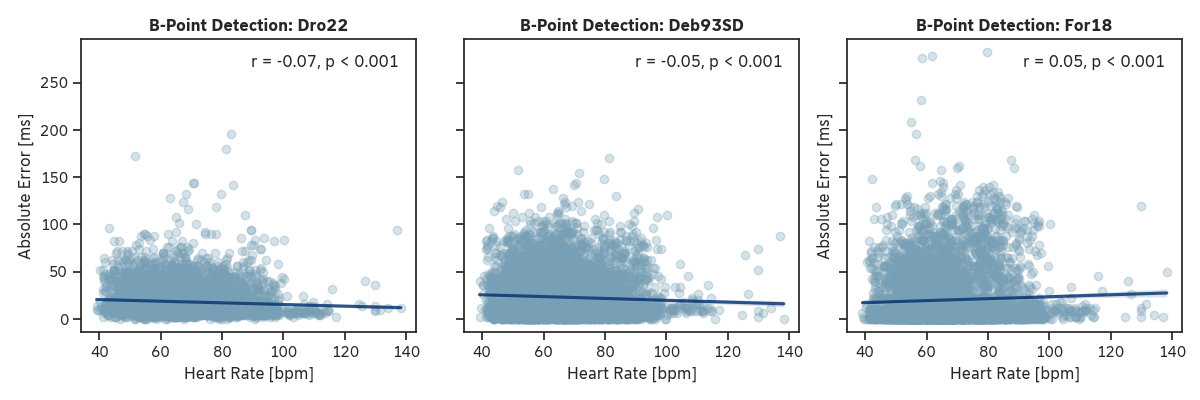

In [96]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

for i, ax in enumerate(axs):
    fig, ax = regplot_error_heart_rate(
        results_guardian_plot,
        selected_algos_for_residual_guardian[i],
        error_metric="absolute_error_per_sample_ms",
        add_corr_coeff=True,
        ax=ax,
    )
    if i != 0:
        axs[1].set_ylabel(None)

fig.tight_layout()

for path in [img_path, suppl_img_path_paper]:
    fig.savefig(path.joinpath("img_b_point_error_heart_rate_guardian.pdf"), transparent=True)

#### Effect of Outlier Correction on Output Error

In [97]:
metrics_guardian_outlier = create_outlier_correction_table(metrics_guardian)
metrics_guardian_outlier_style = metrics_guardian_outlier.style.apply(
    styling.highlight_outlier_improvement, subset=["Mean Absolute Error [ms]", "Invalid PEPs"]
)
metrics_guardian_outlier_style

In [98]:
latex_output = convert_to_latex(
    metrics_guardian_outlier_style,
    collapse_index_columns=False,
    column_header_bold=True,
    siunitx=True,
    convert_css=True,
    column_format="p{1.5cm}p{1.5cm}"
    + ("S[table-column-width=0.75cm]" * (len(metrics_empkins_outlier_style.columns) - 3))
    + "p{1.0cm}" * 3,
    caption=r"Effect of Outlier Correction algorithms on the B-point extraction algorithms for the \textit{Guardian Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order. Resuls highlighted in \textcolor{LightGreen}{green} indicate an improvement of the metric through outlier correction, \textcolor{Pink}{red} indicate no improvement.",
    label="tab:outlier_correction_results_full_guardian",
)

latex_output = latex_output.replace(r"\sisetup{", r"\sisetup{round-mode=places,round-precision=2,")
latex_output = latex_output.replace(r"\bfseries \bfseries", r"\bfseries")
latex_output = latex_output.replace(r"\bfseries \bfseries", r"\bfseries")
latex_output = latex_output.replace(r"\bfseries \bfseries", r"\bfseries")
latex_output = latex_output.replace(r"\multicolumn{2}{r}", r"\multicolumn{2}{c}")
latex_output = latex_output.replace(r"Mean Absolute Error [ms]", r"MAE [ms]")
latex_output = latex_output.replace(r"Mean Error [ms]", r"ME [ms]")
latex_output = latex_output.replace(r"Mean Absolute Relative Error [\%]", r"MARE [\%]")
latex_output = latex_output.replace(r"{B-Point Detection}", r"{B-Point\newline Detection}")

suppl_tab_path_paper.joinpath("tab_outlier_correction_results_full_guardian.tex").open(mode="w+").write(latex_output)

print(latex_output)

\begin{table}[ht]
\centering
\sisetup{round-mode=places,round-precision=2,separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{Effect of Outlier Correction algorithms on the B-point extraction algorithms for the \textit{Guardian Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order. Resuls highlighted in \textcolor{LightGreen}{green} indicate an improvement of the metric through outlier correction, \textcolor{Pink}{red} indicate no improvement.}
\label{tab:outlier_correction_results_full_guardian}
\begin{tabular}{p{1.5cm}p{1.5cm}S[table-column-width=0.75cm]S[table-column-width=0.75cm]S[table-column-width=0.75cm]S[table-column-width=0.75cm]S[table-column-width=0.75cm]S[table-column-width=0.75cm]p{1.0cm}p{1.0cm}p{1.0cm}}
\toprule
{} & {} & \multicolumn{2}{c}{\bfseries MAE [ms]} & \multicolumn{2}{c}{\bfseries ME [ms]} & \multicolumn{2}{c}{\bfseries MARE [\%]} & {\bfseries Valid PEPs} & {\bfseries Invalid PEPs} & {\bfseries Total PEPs} 

#### Horizontal Table

In [99]:
metrics_guardian_outlier_unstack = metrics_guardian_outlier[["Mean Absolute Error [ms]"]]
metrics_guardian_outlier_unstack = (
    metrics_guardian_outlier_unstack.unstack(sort=False).reorder_levels([0, 2, 1], axis=1).sort_index(axis=1)
)
metrics_guardian_outlier_unstack = metrics_guardian_outlier_unstack.reindex(outlier_algos_rename, level=1, axis=1)
metrics_guardian_outlier_unstack

Mean Absolute Error [ms]                                   \
Outlier Correction                     None                LinInt              
                                       Mean         SD       Mean         SD   
B-Point Detection                                                              
Loz07LR                           16.679397  14.766048  17.172790  15.877090   
Ste85                             17.644842  28.238997  21.532112  33.675422   
Dro22                             18.198169  15.228886  19.385776  16.158645   
For18                             18.342700  26.142771  20.121874  29.463117   
Deb93SD                           22.977835  23.872967  24.266538  24.480540   
Loz07QR                           26.375923  18.300131  27.063584  18.662155   
Arb17TD                           29.146122  28.179501  33.978526  34.631430   
She90                             31.220867  21.530961  33.302408  22.471871   
Arb17IC                           31.297271  21.741042  32.848144  22.524930   
Arb17SD                           41.332476  22.143491  43.116257  21.914535   

                                          
Outlier Correction      For18             
                         Mean         SD  
B-Point Detection                         
Loz07LR             17.113429  15.819834  
Ste85               18.262807  29.184824  
Dro22               19.149278  16.048866  
For18               18.453062  26.378166  
Deb93SD             23.584457  24.114538  
Loz07QR             26.434671  18.294916  
Arb17TD             29.479159  27.887583  
She90               31.265169  21.455678  
Arb17IC             31.424398  21.786910  
Arb17SD             41.724116  21.979418

##### To LaTeX

In [100]:
result_table = create_algorithm_result_table(metrics_guardian[["Mean Absolute Error [ms]"]])
result_table = result_table.unstack("Outlier Correction").reindex(result_table.xs("None", level=-1).index, level=0)
result_table = result_table.reindex(outlier_algos_rename, level="Outlier Correction", axis=1)

latex_output = convert_to_latex(
    result_table.style.apply(styling.highlight_min_uncertainty, axis=1),
    collapse_index_columns=False,
    column_header_bold=True,
    siunitx=False,
    column_format="p{1.0cm}p{1.5cm}p{1.5cm}p{1.5cm}",
    caption=r"\ac{MAE} of the Outlier Correction algorithms on the B-point extraction algorithms on the \textit{Guardian Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order. The lowest \ac{MAE} values per algorithm are highlighted in \textbf{bold}. \ac{MAE} values are provided in milliseconds as (\(M\,\pm\,SD\)).",
    label="tab:outlier_correction_results_guardian",
)

# some manual post-processing
latex_output = latex_output.replace(
    r"\multicolumn{3}{r}{\bfseries Mean Absolute Error [ms]}",
    r"\multicolumn{3}{l}{\bfseries Outlier Correction Algorithm}",
)
latex_output = latex_output.replace(r"Outlier Correction & ", r"{\bfseries B-point Algorithm} & ")
latex_output = latex_output.replace(r"B-Point Detection &  &  &  \\", r"")
latex_output = latex_output.replace(r" \pm ", r"\(\pm\)")

tab_path_paper.joinpath("tab_outlier_correction_results_guardian.tex").open(mode="w+").write(latex_output)

print(latex_output)

\begin{table}[ht]
\centering
\sisetup{separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{\ac{MAE} of the Outlier Correction algorithms on the B-point extraction algorithms on the \textit{Guardian Dataset}. The algorithms are sorted by the \acf{MAE} in ascending order. The lowest \ac{MAE} values per algorithm are highlighted in \textbf{bold}. \ac{MAE} values are provided in milliseconds as (\(M\,\pm\,SD\)).}
\label{tab:outlier_correction_results_guardian}
\begin{tabular}{p{1.0cm}p{1.5cm}p{1.5cm}p{1.5cm}}
\toprule
 & \multicolumn{3}{l}{\bfseries Outlier Correction Algorithm} \\
{\bfseries B-point Algorithm} & \bfseries None & \bfseries LinInt & \bfseries For18 \\

\midrule
Loz07LR & \bfseries 16.7\(\pm\)14.8 & 17.2\(\pm\)15.9 & 17.1\(\pm\)15.8 \\
Dro22 & \bfseries 18.2\(\pm\)15.2 & 19.4\(\pm\)16.2 & 19.1\(\pm\)16.0 \\
For18 & 20.1\(\pm\)29.5 & \bfseries 18.3\(\pm\)26.1 & 18.5\(\pm\)26.4 \\
Ste85 & 21.5\(\pm\)33.7 & \bfseries 17.6\(\pm\)28.2 & 18.3\(\

#### Outlier Correction Residual Plots

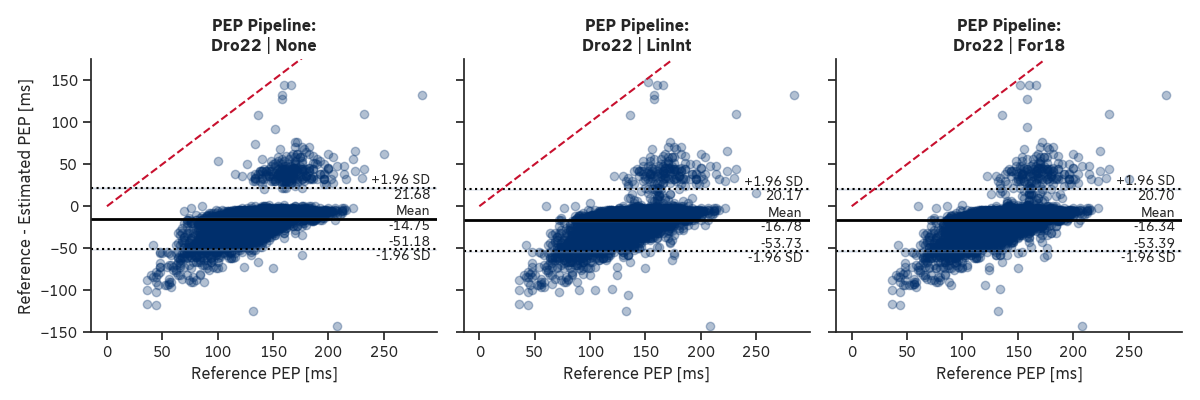

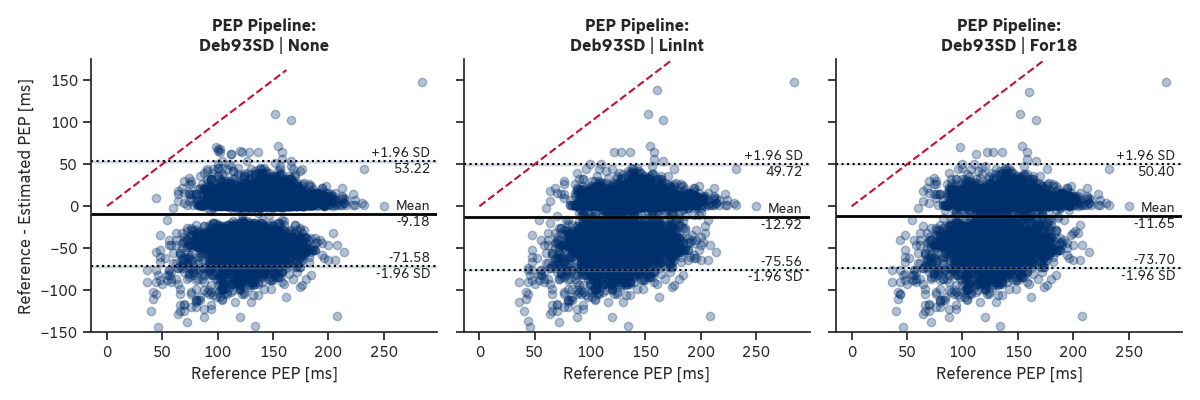

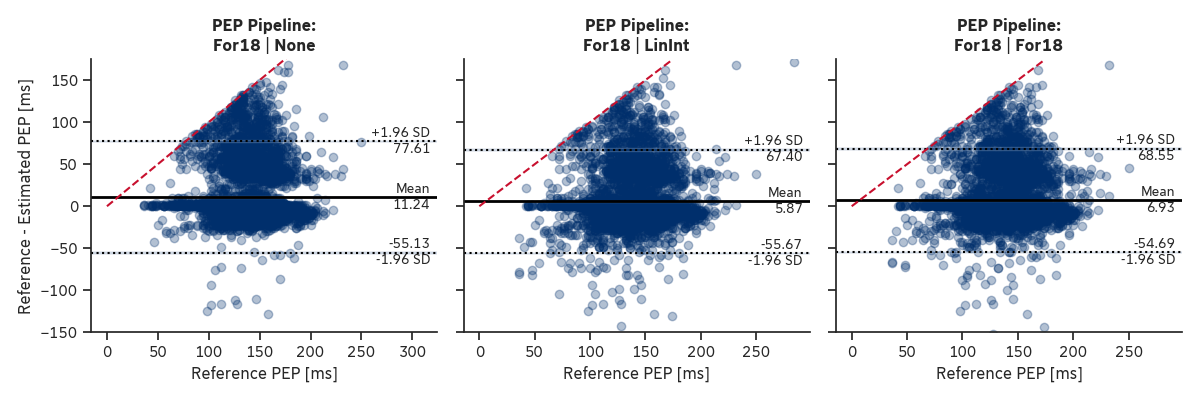

In [101]:
for algo in selected_algos_for_residual_outlier_correction_guardian:
    fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

    results_per_algorithm_plot_guardian = results_per_sample_guardian.xs(
        algo, level="b_point_algorithm", drop_level=False
    )

    for i, outlier_algo in enumerate(outlier_algos):
        selected_algo = [algo, outlier_algo]
        residual_plot_pep(
            results_per_sample_guardian, selected_algo, ax=axs[i], show_upper_limit=True, annotate_fontsize="small"
        )
        if i != 0:
            axs[i].set_ylabel(None)
        axs[i].set_ylim([-150, 175])

    fig.tight_layout()
    for path in [img_path, suppl_img_path_paper]:
        fig.savefig(
            path.joinpath(f"img_residual_plots_b_point_outlier_correction_{algo}_guardian.pdf"), transparent=True
        )

**B-point Algorithm**: drost2022

**Outlier Correction Algorithms**: none vs. linear-interpolation

improvement  no change deterioration
improvement_percent    1.381082  91.424442      7.194476

**Outlier Correction Algorithms**: none vs. forouzanfar2018

improvement no change deterioration
improvement_percent    1.204432  92.35587      6.439698

**B-point Algorithm**: debski1993-second-derivative

**Outlier Correction Algorithms**: none vs. linear-interpolation

improvement  no change deterioration
improvement_percent    2.858978  90.860906      6.280116

**Outlier Correction Algorithms**: none vs. forouzanfar2018

improvement  no change deterioration
improvement_percent     2.39319  93.334404      4.272406

**B-point Algorithm**: forouzanfar2018

**Outlier Correction Algorithms**: none vs. linear-interpolation

improvement no change deterioration
improvement_percent    6.458023  89.89899      3.642987

**Outlier Correction Algorithms**: none vs. forouzanfar2018

improvement  no change deterioration
improvement_percent    5.845339  91.025004      3.129657

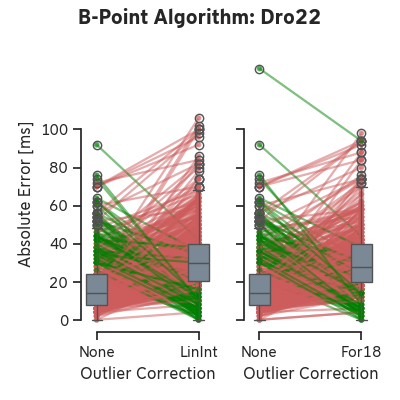

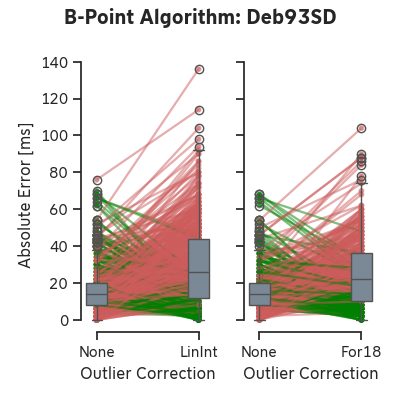

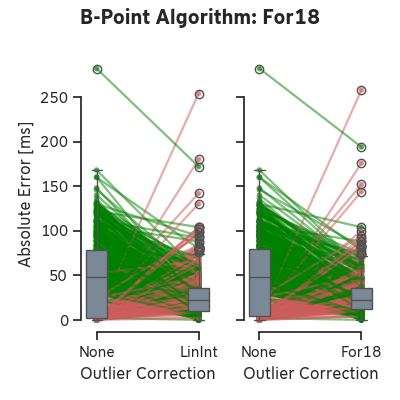

In [102]:
dv = "absolute_error_per_sample_ms"

for algo in selected_algos_for_residual_outlier_correction_guardian:
    results_per_algorithm_plot_guardian = results_per_sample_guardian.xs(algo, level="b_point_algorithm")
    data_plot_paired = add_unique_id_to_results_dataframe(results_per_algorithm_plot_guardian[[dv]])

    outlier_algo_combis = [(outlier_algos[0], outlier_algos[1]), (outlier_algos[0], outlier_algos[2])]

    fig, axs = plt.subplots(ncols=2, figsize=(4, 4), sharey=True)
    fig, axs = paired_plot_error_outlier_correction(
        data=data_plot_paired, outlier_algo_combis=outlier_algo_combis, dv=dv, title=algo, axs=axs
    )

    display(Markdown(f"**B-point Algorithm**: {algo}"))
    for outlier_algo in outlier_algo_combis:
        display(Markdown(f"""**Outlier Correction Algorithms**: {' vs. '.join(outlier_algo)}"""))
        display(compute_improvement_outlier_correction(data_plot_paired, outlier_algo))

    fig.tight_layout()
    for path in [img_path, suppl_img_path_paper]:
        fig.savefig(
            path.joinpath(f"img_paired_plot_b_point_outlier_correction_improvement_{algo}_guardian.pdf"),
            transparent=True,
        )

### `NaN` Reason Table

In [103]:
nan_reason_table_guardian = create_nan_reason_table(
    results_per_sample_guardian, outlier_algos=outlier_algos, use_short_names=True
)
nan_reason_table_guardian.head()

Reason                                No C  Inv. B Window  Neg. PEP  \
B-Point Detection Outlier Correction                                  
Arb17IC           None                 367              0        21   
                  LinInt               367              0        14   
                  For18                367              0        14   
Arb17SD           None                 367              0        25   
                  LinInt               367              0        24   

Reason                                No Loc. Min.  No Mon. Incr.  No ZCs  
B-Point Detection Outlier Correction                                       
Arb17IC           None                           0              0       0  
                  LinInt                         0              0       0  
                  For18                          0              0       0  
Arb17SD           None                           0              0       0  
                  LinInt                         0              0       0

##### To LaTeX

In [104]:
latex_output = convert_to_latex(
    nan_reason_table_guardian,
    column_format="p{1.5cm}" * 2 + "p{1.0cm}" * len(nan_reason_table_empkins.columns),
    column_header_bold=True,
    escape_columns=True,
    caption=r"Overview of invalid PEP reasons for different B-point algorithms on the \textit{Guardian Dataset}. Abbreviations: "
    + ", ".join([rf"\textit{{{k}}}: {v}" for k, v in get_nan_reason_mapping().items()]),
    label="tab:nan_reasons_guardian",
)

# some manual post-processing
latex_output = latex_output.replace(r"\centering", r"\small\centering")
latex_output = latex_output.replace(r"{Reason}", r"{\bfseries Reason}")

suppl_tab_path_paper.joinpath("tab_b_point_nan_reason_guardian.tex").open(mode="w+").write(latex_output)
print(latex_output)

\begin{table}[ht]
\small\centering
\sisetup{separate-uncertainty=true,multi-part-units=single,table-align-uncertainty=true}
\caption{Overview of invalid PEP reasons for different B-point algorithms on the \textit{Guardian Dataset}. Abbreviations: \textit{No C}: No C-point detected, \textit{No R}: No R-peak detected, \textit{Neg. PEP}: Negative PEP, \textit{No IC}: No Isoelectric Crossing before C-point detected, \textit{No Loc. Min.}: No Local Minimum detected, \textit{No Mon. Incr.}: No Monotonically Increasing Segment detected, \textit{No ZCs}: No Zero Crossings detected, \textit{Inv. B Window}: Invalid B-point Search Window}
\label{tab:nan_reasons_guardian}
\begin{tabular}{p{1.5cm}p{1.5cm}p{1.0cm}p{1.0cm}p{1.0cm}p{1.0cm}p{1.0cm}p{1.0cm}}
\toprule
{} & {\bfseries Reason} & {\bfseries No C} & {\bfseries Inv. B Window} & {\bfseries Neg. PEP} & {\bfseries No Loc. Min.} & {\bfseries No Mon. Incr.} & {\bfseries No ZCs} \\
{B-Point Detection} & {Outlier Correction} & {} & {} & {} & {} & {}

## Combined Figures

### Absolute Error - EmpkinS and Guardian

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 2), sharey=True)

boxplot_algorithm_performance(
    results_empkins_plot,
    metric="absolute_error_per_sample_ms",
    showmeans=True,
    showfliers=False,
    width=0.9,
    title="EmpkinS Dataset – B-Point Detection",
    fig=fig,
    ax=axs[0],
)
boxplot_algorithm_performance(
    results_guardian_plot,
    metric="absolute_error_per_sample_ms",
    showmeans=True,
    showfliers=False,
    width=0.9,
    title="Guardian Dataset – B-Point Detection",
    fig=fig,
    ax=axs[1],
)
for ax in axs:
    ax.set_xlabel(None)
axs[1].set_ylabel(None)

fig.tight_layout()

for path in [img_path, img_path_paper]:
    fig.savefig(path.joinpath("img_boxplot_b_point_algorithms_mae_combined.pdf"), transparent=True)

### Outlier Correction - Residual and Paired Plots (Guardian)

In [ ]:
selected_algo = "forouzanfar2018"
dv = "absolute_error_per_sample_ms"

fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=False)
selected_results_guardian = results_per_sample_guardian.xs(selected_algo, level="b_point_algorithm", drop_level=True)
selected_outlier_algos = ["none", "forouzanfar2018"]
for outlier_algo, ax in zip(selected_outlier_algos, axs):
    residual_plot_pep(selected_results_guardian, outlier_algo, ax=ax, show_upper_limit=True)
    ax.set_ylim([-150, 175])

axs[1].set_ylabel(None)
axs[1].set_yticklabels([])

selected_results_guardian = results_per_sample_guardian.xs(selected_algo, level="b_point_algorithm", drop_level=True)
data_plot_paired = add_unique_id_to_results_dataframe(selected_results_guardian[[dv]])
paired_plot_error_outlier_correction(
    data=data_plot_paired, outlier_algo_combis=[selected_outlier_algos], dv=dv, axs=[axs[-1]]
)

axs[-1].set_title("Effect of Outlier Correction\n on Absolute Error", fontweight="bold")
axs[-1].set_xlabel("Outlier Correction Algorithm")

display(Markdown(f"""**Outlier Correction Algorithms**: {' vs. '.join(selected_outlier_algos)}"""))
display(compute_improvement_outlier_correction(selected_results_guardian[[dv]], selected_outlier_algos))

fig.tight_layout()

for path in [img_path, img_path_paper]:
    fig.savefig(path.joinpath("img_effect_outlier_correction_guardian_combined.pdf"), transparent=True)